# **Modeling Notebook**

- This Notebook will be used for testing different models which will then be included in the final Vignette report.

We will be testing the following models:
- **Simple CNN**
    - 2 Convolution Layers with 64 filters for the first 2 and 128 for the second,
    - Maxpooling
    - and a Dense Layer with 128 nodes with a dropout of 50%
- **Hyperband Parameter Training**
    - Uses Keras Hyperband Tuning to start with different architectures at lower epochs and slowly removes unpromising setups, and keeps the best ones and trains further
- **Bayesian Optimization**
    - Uses Optuna to efficiently search the hyperparameter space by modeling the objective function and selecting hyperparameters that are expected to improve the model's performance. This approach is particularly useful for optimizing complex models with many hyperparameters.
- Pre-trained Model additional layering
    - on top of convolution layers to improve 
    - by how much does it improve

Considerations:
- Do we need to consider a better data set?
- how can we get better performance?

In [2]:
##### library imports ##### 

# preprocessing and splitting data packages
import os
from Preprocessing import preprocess_data
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
import pickle
import matplotlib.pyplot as plt
# modeling data packages
import keras
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
import optuna # for bayesian optimization

# set random seeds
np.random.seed(12345)
tf.random.set_seed(12345)
keras.utils.set_random_seed(12345)

# Preprocess Data from Preprocessing file

- Pulls 400 Brain Tumor MRI images from each of 4 different classes, including:
    - Glioma
    - Meningioma  
    - Pituitary
    - Normal (no tumor)

- Ensures they are normalizes, resized, and Grayscaled for quicker computation

In [3]:
my_dir = os.getcwd()
print(f"Current working directory: {my_dir}")

# change this accordingly but should work for all users
glioma_path = my_dir[:-15] + "/data/glioma_tumor"
meningioma_path = my_dir[:-15] + "/data/meningioma_tumor"
pituitary_path = my_dir[:-15] + "/data/pituitary_tumor"
normal_path = my_dir[:-15] + "/data/normal_tumor"


# preprocess data
n_samples = 600 # more than 600 in each class
seed = 1234 # reproducibility
glioma_data, glioma_labels = preprocess_data(glioma_path, n_samples, seed)
print("processed glioma data")
print(glioma_data.shape)
meningioma_data, meningioma_labels = preprocess_data(meningioma_path, n_samples, seed)
print("processed meningioma data")
print(meningioma_data.shape)
pituitary_data, pituitary_labels = preprocess_data(pituitary_path, n_samples, seed)
print("processed pituitary data")
print(pituitary_data.shape)
normal_data, normal_labels = preprocess_data(normal_path, n_samples, seed)
print("processed normal data")
print(normal_data.shape)
if glioma_data.shape != meningioma_data.shape or pituitary_data.shape != normal_data.shape:
    raise ValueError("All data must have the same shape")
else:
    print("All data have the same shape")

# combine all data and labels
data = np.concatenate([glioma_data, meningioma_data, pituitary_data, normal_data])
labels = np.concatenate([glioma_labels, meningioma_labels, pituitary_labels, normal_labels])
print(f"Combined data and labels shape: {data.shape}, {labels.shape}")

# split data into training and testing and validation sets
train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)
train_small, val_data, train_small_labels, val_labels = train_test_split(train_data, train_labels, test_size=0.25, random_state=42)

# one hot encode labels
label_encoder = OneHotEncoder(sparse_output=False)
train_labels = label_encoder.fit_transform(np.array(train_labels).reshape(-1, 1))
test_labels = label_encoder.transform(np.array(test_labels).reshape(-1, 1))
train_small_labels = label_encoder.transform(np.array(train_small_labels).reshape(-1, 1))
val_labels = label_encoder.transform(np.array(val_labels).reshape(-1, 1))

Current working directory: /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/glioma_tumor: 901
Selected files: 400
Processed 400 images.
processed glioma data
(400, 128, 128, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/meningioma_tumor: 913
Selected files: 400
Processed 400 images.
processed meningioma data
(400, 128, 128, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/pituitary_tumor: 843
Selected files: 400
Processed 400 images.
processed pituitary data
(400, 128, 128, 1)
Total files in /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/data/normal_tumor: 633
Selected files: 400
Processed 400 images.
processed normal data
(400, 128, 128, 1)
All data have the same shape
Combined data and labels shape: (1600, 128, 128, 1), (1600,)


# Visually Inspect

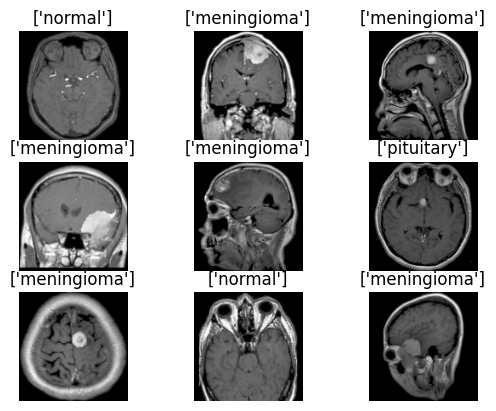

In [4]:
# inverse transform labels
labels = label_encoder.inverse_transform(train_labels)

# show images from training set
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.imshow(train_data[i], cmap="gray")
    plt.axis('off')
    plt.title((labels[i]))
plt.show()

# Modeling
- ### We first can start with a simple convolution model as a base level to see how well one archictecture will learn on the training data set.
- ### Next, we will apply a hyperparameter tuning technique, called Hyperband tuning, to find the best setup.
     - Hyperband tuning performs a combination of random search and early stopping to efficiently explore hyperparameter configurations. It allocates resources to promising configurations while quickly discarding those that are underperforming, allowing for faster convergence to optimal hyperparameters.

# Simple CNN to Start

### What is a CNN?
A CNN (convolutional neural network) is a type of network that specializes in processing and predicting grid-like data, making it especially useful for image classification. It utilizes automatic detection of spatial hierarchies and patterns with layers of convolutional filters. Unlike the classic feed-forward network, which connects each neuron to every neuron in the next layer, a CNN uses local receptive fields and shared weights in its convolutional layers, which reduces the number of parameters significantly, and improves the efficiency of the model. 

### Model Flow
- In our example, the filters will pickup on different shapes, edges, and other patterns in the image, by sliding multiple 3x3 kernels convolving with the input image.
- After this we, apply a pooling function of either averaging or maximizing which typically halves the size of our convolved feature.
- Then after another round of convolving and maxpool, we flatten it and pass to a Dense neural network of hidden layers
- Finally the output layer is activated by a softmax function to provide us with probabilities of the classes. 

In [6]:
# Initialize model
model = Sequential([
  Conv2D(filters=64, kernel_size=(3,3), activation='relu', input_shape=(128, 128, 1)),
  MaxPooling2D(2), # reduce dimensionality
  Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
  MaxPooling2D(2), # reduce dimensionality
  Flatten(), # flatten the data to feed into the dense layers
  Dense(units=128, activation='relu'),
  Dropout(0.5), # prevent overfitting
  Dense(units=4, activation='softmax') # output layer
])

model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 64)   │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 61, 61, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 115200)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │    14,745,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,820,740 (56.54 MB)

 Trainable params: 14,820,740 (56.54 MB)

 Non-trainable params: 0 (0.00 B)

# Training the model

Epoch 1/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 311ms/step - accuracy: 0.2803 - loss: 1.6165 - val_accuracy: 0.4766 - val_loss: 1.2692
Epoch 2/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 312ms/step - accuracy: 0.4223 - loss: 1.2493 - val_accuracy: 0.5703 - val_loss: 1.0530
Epoch 3/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 12s 373ms/step - accuracy: 0.5979 - loss: 0.9852 - val_accuracy: 0.6680 - val_loss: 0.8378
Epoch 4/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 325ms/step - accuracy: 0.6962 - loss: 0.8101 - val_accuracy: 0.6836 - val_loss: 0.8116
Epoch 5/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 317ms/step - accuracy: 0.7441 - loss: 0.6974 - val_accuracy: 0.7188 - val_loss: 0.6802
Epoch 6/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 10s 319ms/step - accuracy: 0.7684 - loss: 0.5896 - val_accuracy: 0.7461 - val_loss: 0.6347
Epoch 7/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 339ms/step - accuracy: 0.7922 - loss: 0.4957 - val_accuracy: 0.7578 - val_loss: 0.6072
Epoch 8/20
32/32 ━━━━━━━━━━━━━━━━━━━━ 11s 338ms/step - accuracy: 0.8517 - loss: 0.3813 - val_accu

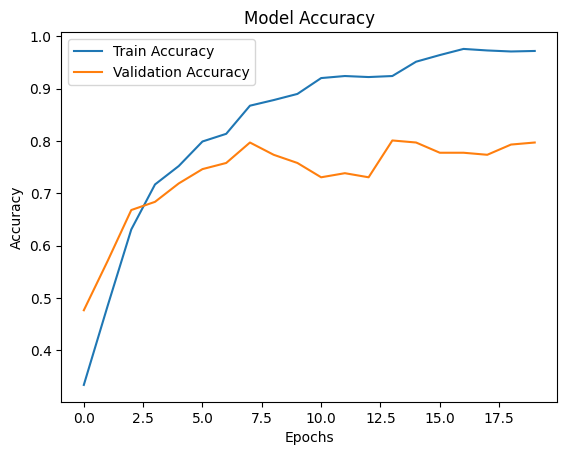

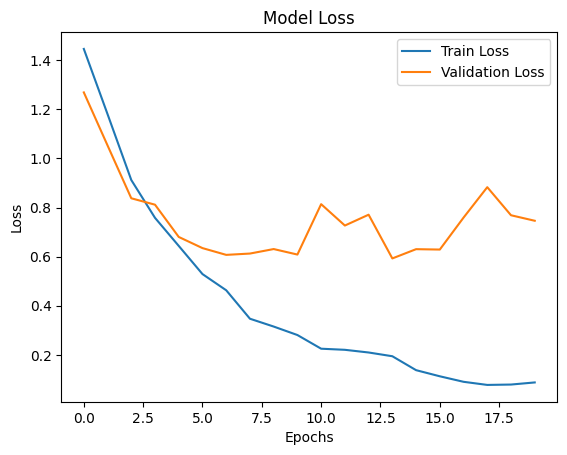

In [7]:
# Train the model # 

# Early stopping will stop training when the validation loss stops improving for a few epochs, preventing overfitting
early_stopping = EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True)

history = model.fit(
    train_data,
    train_labels,
    validation_split=0.2, # Convert sparse matrix
    epochs=20,
    batch_size=32, # mini batch size
    callbacks=[early_stopping]
)

# Evaluate model on test set
test_loss, test_accuracy = model.evaluate(test_data, test_labels)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot training and validation loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# TODO LATER once decent performance on simple CNN:
HyperParameter Tuning
- We will apply Hyperband Parameter Tuning to find our best set of params
- Then once we have the best set of hyperparams, we will build a final model and train with those parameters on the full training set.

In [9]:
# building a hyperband model to find the best model architecture
def build_model(hp):
    '''Hyperband function to test different model architectures'''
    # initialize the model
    model = Sequential([
        Conv2D(filters=hp.Int('conv_1_filter', min_value=32, max_value=128, step=16),
               kernel_size=hp.Choice('conv_1_kernel', values=[3,5]),
               activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(2),
        Conv2D(filters=hp.Int('conv_2_filter', min_value=32, max_value=256, step=16),
               kernel_size=hp.Choice('conv_2_kernel', values=[3,5]),
               activation='relu'),
        MaxPooling2D(2),
        Conv2D(filters=hp.Int('conv_3_filter', min_value=32, max_value=256, step=16),
               kernel_size=3,
               activation='relu'),
        MaxPooling2D(2),
        Flatten(),
        Dense(units=hp.Int('dense_1_units', min_value=128, max_value=512, step=32),
              activation='relu'),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.5, step=0.1)),
        Dense(4, activation='softmax')
    ])
    # compile the model
    model.compile(
        optimizer=keras.optimizers.Adam(),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model
# initialize tuner
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=20,
    factor=5,
    directory=my_dir[:-15] + "/scripts/drafts/model_trials",  # Use temporary directory
    project_name='hp_tuning',
    overwrite=False
)
# search for the best hyperparameters
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
tuner.search(
    train_small, train_small_labels,
    epochs=5,
    batch_size=32, 
    validation_data=(val_data, val_labels),
    callbacks=[early_stopping],
    verbose=1
)
# Get the best hyperparameters directly
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best Hyperparameters:")
print(best_hp.values)
# build the best model
Hyperband_model = tuner.hypermodel.build(best_hp)
Hyperband_model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])
Hyperband_model.summary()

Reloading Tuner from /Users/reese/Documents/School/UC Santa Barbra/PSTAT/PSTAT197/vignette-cnn/scripts/drafts/model_trials/hp_tuning/tuner0.json
Best Hyperparameters:
{'conv_1_filter': 48, 'conv_1_kernel': 5, 'conv_2_filter': 32, 'conv_2_kernel': 3, 'conv_3_filter': 80, 'dense_1_units': 256, 'dropout_1': 0.2, 'tuner/epochs': 20, 'tuner/initial_epoch': 0, 'tuner/bracket': 0, 'tuner/round': 0}


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 124, 124, 48)   │         1,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 62, 62, 48)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 60, 60, 32)     │        13,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 30, 30, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 28, 28, 80)     │        23,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 14, 14, 80)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 15680)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     4,014,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         1,028 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,053,588 (15.46 MB)

 Trainable params: 4,053,588 (15.46 MB)

 Non-trainable params: 0 (0.00 B)

Once we have our best model, we can then build using the best architecture and train on the full data set.

Epoch 1/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 174ms/step - accuracy: 0.3180 - loss: 1.3560 - val_accuracy: 0.5469 - val_loss: 1.1343
Epoch 2/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 165ms/step - accuracy: 0.5901 - loss: 1.0003 - val_accuracy: 0.6094 - val_loss: 0.9906
Epoch 3/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 148ms/step - accuracy: 0.6853 - loss: 0.7918 - val_accuracy: 0.7135 - val_loss: 0.7350
Epoch 4/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 167ms/step - accuracy: 0.7876 - loss: 0.5580 - val_accuracy: 0.7656 - val_loss: 0.5996
Epoch 5/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.8298 - loss: 0.4534 - val_accuracy: 0.7708 - val_loss: 0.6390
Epoch 6/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 150ms/step - accuracy: 0.8715 - loss: 0.3468 - val_accuracy: 0.7917 - val_loss: 0.5532
Epoch 7/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 6s 183ms/step - accuracy: 0.8931 - loss: 0.2928 - val_accuracy: 0.7604 - val_loss: 0.5885
Epoch 8/50
34/34 ━━━━━━━━━━━━━━━━━━━━ 5s 156ms/step - accuracy: 0.9503 - loss: 0.1515 - val_accuracy: 0.

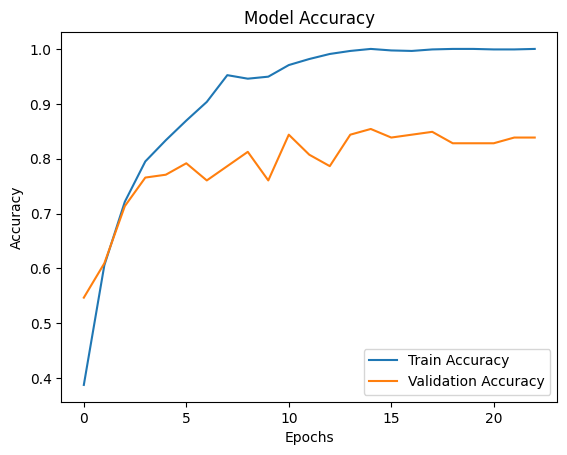

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.8207 - loss: 1.0111
Test Loss: 1.1105726957321167
Test Accuracy: 0.8125


In [11]:
# early stopping
early_stopping = EarlyStopping(monitor='val_accuracy', patience=8, restore_best_weights=True)
history = Hyperband_model.fit(train_data, train_labels, 
                epochs=50,
                validation_split=0.15,  
                batch_size=32,
                callbacks=[early_stopping])

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# evaluate the best model on the test set
Hyperband_test_loss, Hyperband_test_accuracy = Hyperband_model.evaluate(test_data, test_labels)
print(f"Test Loss: {Hyperband_test_loss}")
print(f"Test Accuracy: {Hyperband_test_accuracy}")

### Combining with GLCM
- Extract features from the cnn and the GLCM and combine to see if the model improves

In [10]:
from skimage.feature import graycomatrix, graycoprops

def extract_glcm_features(image):
    '''Extract GLCM features from an image'''
    # change to 2d image from 3d
    image = image.squeeze()
    image = (image * 255).astype(np.uint8) # normalize back to 0-255 (instead of 0-1)
    glcm = graycomatrix(image, distances=[1], angles=[0], levels=256, symmetric=True, normed=True)
    # extract features
    contrast = graycoprops(glcm, 'contrast')[0, 0]
    dissimilarity = graycoprops(glcm, 'dissimilarity')[0, 0]
    homogeneity = graycoprops(glcm, 'homogeneity')[0, 0]
    energy = graycoprops(glcm, 'energy')[0, 0]
    correlation = graycoprops(glcm, 'correlation')[0, 0]
    asm = graycoprops(glcm, 'ASM')[0, 0]
    return [contrast, dissimilarity, homogeneity, energy, correlation, asm]

glcm_features_train = np.array([extract_glcm_features(img) for img in train_data])
glcm_features_test = np.array([extract_glcm_features(img) for img in test_data])

In [18]:
# build new model with cnn best hps from hyperband
def build_optimized_model(best_hp):
    '''Build a model with optimized hyperparameters'''
    # build the model
    model = Sequential([
        Conv2D(filters=best_hp.values['conv_1_filter'],
               kernel_size=best_hp.values['conv_1_kernel'],
               activation='relu', input_shape=(128, 128, 1)),
        MaxPooling2D(2),
        Conv2D(filters=best_hp.values['conv_2_filter'],
               kernel_size=best_hp.values['conv_2_kernel'],
               activation='relu'),
        MaxPooling2D(2),
        Conv2D(filters=best_hp.values['conv_3_filter'],
               kernel_size=3,
               activation='relu'),
        MaxPooling2D(2),
        Flatten(),
    ])
    return model


# build the model
cnn_model = build_optimized_model(best_hp)

# get the cnn features
cnn_features_train = cnn_model.predict(train_data)
cnn_features_test = cnn_model.predict(test_data)
# combine the cnn features and the glcm features
combined_features_train = np.concatenate([cnn_features_train, glcm_features_train], axis=1)
combined_features_test = np.concatenate([cnn_features_test, glcm_features_test], axis=1)

combined_model = Sequential([
    Dense(units=best_hp.values['dense_1_units'], 
          activation='relu', 
          input_shape=(combined_features_train.shape[1],)),
    Dropout(rate=best_hp.values['dropout_1']),
    Dense(4, activation='softmax') # output layer
])

combined_model.compile(optimizer=keras.optimizers.Adam(), 
              loss='categorical_crossentropy', 
              metrics=['accuracy', 'AUC'])

early_stopping = EarlyStopping(monitor='val_accuracy', patience=7, restore_best_weights=True)
combined_model.fit(combined_features_train, train_labels,
                   epochs = 50,
                   batch_size=32,
                   validation_split=0.2,
                   callbacks=[early_stopping])

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 37ms/step
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
Epoch 1/50


/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - AUC: 0.5347 - accuracy: 0.2755 - loss: 3.5971 - val_AUC: 0.6238 - val_accuracy: 0.3086 - val_loss: 1.4525
Epoch 2/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - AUC: 0.6162 - accuracy: 0.3578 - loss: 1.7664 - val_AUC: 0.7304 - val_accuracy: 0.4375 - val_loss: 1.2196
Epoch 3/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - AUC: 0.7432 - accuracy: 0.4834 - loss: 1.2245 - val_AUC: 0.7756 - val_accuracy: 0.5234 - val_loss: 1.1394
Epoch 4/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.7686 - accuracy: 0.5294 - loss: 1.1592 - val_AUC: 0.8048 - val_accuracy: 0.5586 - val_loss: 1.0689
Epoch 5/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.7958 - accuracy: 0.5371 - loss: 1.0880 - val_AUC: 0.8334 - val_accuracy: 0.6016 - val_loss: 1.0168
Epoch 6/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC: 0.8289 - accuracy: 0.5756 - loss: 1.0180 - val_AUC: 0.8604 - val_accuracy: 0.6445 - val_loss: 0.9665
Epoch 7/50
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - AUC:

In [19]:
# testing performance
combined_test_loss, combined_test_accuracy, combined_test_auc = combined_model.evaluate(combined_features_test, test_labels)
print(f"Test Loss: {combined_test_loss}")
print(f"Test Accuracy: {combined_test_accuracy}")
print(f"Test AUC: {combined_test_auc}")

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - AUC: 0.9136 - accuracy: 0.7473 - loss: 0.7180
Test Loss: 0.7600533366203308
Test Accuracy: 0.7406250238418579
Test AUC: 0.905784547328949


## Comparing Hyperband Model with Combined GLCM + Tuned CNN Model